In [ ]:
#INSTALLING AND IMPORTING DEPENDENCIES

In [ ]:
!pip install spacy==2.2.3
!pip install beautifulsoup4==4.9.1
!pip install textblob==0.15.3
from spacy.lang.en import English
!pip install git+https://github.com/laxmimerit/preprocess_kgptalkie.git --upgrade --force-reinstall
import pandas as pd
import preprocess_kgptalkie as ps
import re
import nltk
import matplotlib.pyplot as plt
import random
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split 
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import MultinomialNB


  Cloning https://github.com/laxmimerit/preprocess_kgptalkie.git to /tmp/pip-req-build-hyoghqwx
  Running command git clone -q https://github.com/laxmimerit/preprocess_kgptalkie.git /tmp/pip-req-build-hyoghqwx
  Created wheel for preprocess-kgptalkie: filename=preprocess_kgptalkie-0.1.3-cp37-none-any.whl size=11759 sha256=ed48248fba184b3226a9fe9c02cad06ca40ad2fc79dd099f761f85edd55ccd01
  Stored in directory: /tmp/pip-ephem-wheel-cache-gz6qg_67/wheels/a8/18/22/90afa4bd43247fb9a75b710a4a3fcd94966c022ce9e3c7d0a6
Successfully built preprocess-kgptalkie
  Found existing installation: preprocess-kgptalkie 0.1.3
    Uninstalling preprocess-kgptalkie-0.1.3:
      Successfully uninstalled preprocess-kgptalkie-0.1.3


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


IMPORTING & READING DATA

In [ ]:
df=pd.read_csv("https://txtminer.s3.amazonaws.com/IMDB_Dataset.csv")
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


**DATA DESCRIPTION**

DATASET BALANCE

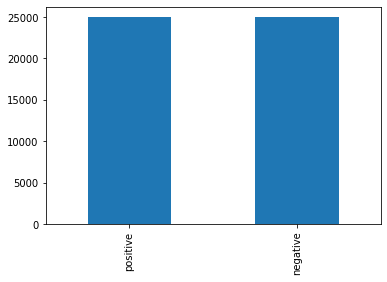

In [ ]:
df['sentiment'].value_counts().plot(kind='bar')

In [ ]:
df['sentiment'].value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

NOTES: The distribution above clearly incicates a balanced dataset, which is not skewed to any particular side.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In pandas, an object is a string, therefore it performs a string operation rather than a mathematical one.

In [ ]:
#Word_count in reviews
word_counts = df['review'].apply(lambda x: len(x.split()))

word_counts.describe()

count    50000.000000
mean       231.156940
std        171.343997
min          4.000000
25%        126.000000
50%        173.000000
75%        280.000000
max       2470.000000
Name: review, dtype: float64

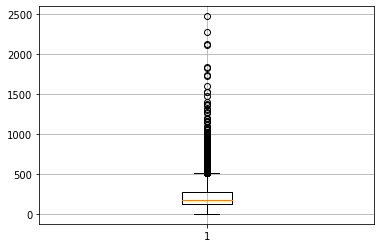

In [ ]:
plt.boxplot(word_counts.values)
plt.grid(True)
plt.show()

There is an average of 231 words in the reviews, with 75% being 280 words.

**RELABELING DATASET (SENTIMENTS)**

In [ ]:
labeling = {
    'positive':1, 
    'negative':0
}

df['sentiment'] = df['sentiment'].apply(lambda x : labeling[x])

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production. <br /><br />The...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically there's a family where a little boy ...,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


**CLEANING DATA**

In [ ]:
def get_clean(x):
    x = str(x).lower().replace('\\', '').replace('_', ' ')
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.remove_html_tags(x)
    x = ps.remove_accented_chars(x)
    x = ps.remove_special_chars(x)
    x = re.sub("(.)\\1{2,}", "\\1", x)
    return x

In [ ]:
df['review'] = df['review'].apply(lambda x: get_clean(x))

In [ ]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production the filming tech...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1


TOKENIZATION, STOPWORDS AND LEMMATIZATION

In [ ]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords.remove('not')
lemmatizer = WordNetLemmatizer()

def data_preprocessing(review):


  #tokenization
  tokens = nltk.word_tokenize(review) 

  #stopwords removal
  review = [word for word in tokens if word not in stopwords]

  #POS_tagger
  #tagged_review = nltk.pos_tag(review)

  #lemmatization
  review = [lemmatizer.lemmatize(word) for word in review]
 
  #join words in preprocessed review

  review = ' '.join(review)

  return review

In [ ]:
df['review'] = df['review'].apply(lambda review: data_preprocessing(review))
df.head()

,review,sentiment
0,one reviewer mentioned watching 1 oz episode y...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there family little boy jake think t...,0
4,petter matteis love time money visually stunni...,1


In [ ]:
#word_count in reviews
word_counts = df['review'].apply(lambda x: len(x.split()))

word_counts.describe()

count    50000.000000
mean       120.986680
std         90.744949
min          3.000000
25%         65.000000
50%         90.000000
75%        147.000000
max       1431.000000
Name: review, dtype: float64

In [ ]:
#IMPORTING LIBRARIES

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1,4), analyzer='char')
X = vectorizer.fit_transform(df['review'])
X
y=df['sentiment']

WORD FREQUENCY COUNT

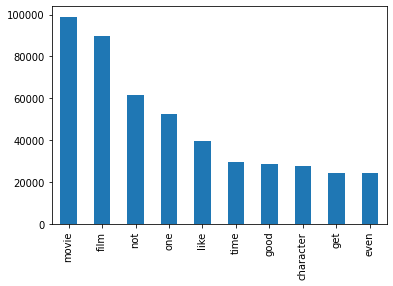

In [ ]:
word_freq = df.review.str.split(expand=True).stack().value_counts()
word_freq[:10].plot(kind='bar')

In [ ]:
from sklearn.model_selection import train_test_split 
import random
X_train, X_test, y_train, y_test = train_test_split(X, df['sentiment'], test_size=15000, random_state=42)

print('Train data size', X_train.shape)
print('Test data size', X_test.shape)

Train data size (35000, 1000)
Test data size (15000, 1000)


Train dummy classifier as a baseline

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report

# Train classifier
clf = DummyClassifier()
clf.fit(X_train, y_train)

# Evaluate
predicted = clf.predict(X_test)
report = classification_report(y_true=y_test, y_pred=predicted)
print(report)

              precision    recall  f1-score   support

           0       0.49      0.51      0.50      7411
           1       0.51      0.49      0.50      7589

    accuracy                           0.50     15000
   macro avg       0.50      0.50      0.50     15000
weighted avg       0.50      0.50      0.50     15000



/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


CONFUSION MATIRIX

Confusion matrix, without normalization
[[3664 3747]
 [3849 3740]]
Normalized confusion matrix
[[0.49723384 0.50276616]
 [0.50665437 0.49334563]]


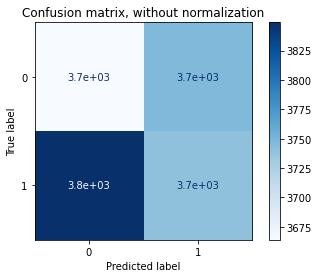

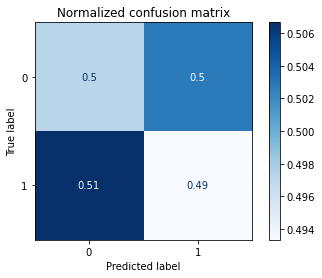

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix

#class_names=documents.label
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Naive Bayes Classifier

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report

# Train classifier
clf = MultinomialNB()
clf.fit(X_train, y_train)

# Evaluate
predicted = clf.predict(X_test)
report = classification_report(y_true=y_test, y_pred=predicted)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.73      0.73      7411
           1       0.73      0.73      0.73      7589

    accuracy                           0.73     15000
   macro avg       0.73      0.73      0.73     15000
weighted avg       0.73      0.73      0.73     15000



CONFUSION MATIRIX

Confusion matrix, without normalization
[[5392 2019]
 [2043 5546]]
Normalized confusion matrix
[[0.72756713 0.27243287]
 [0.26920543 0.73079457]]


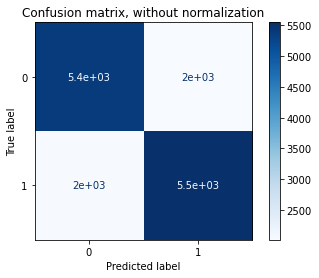

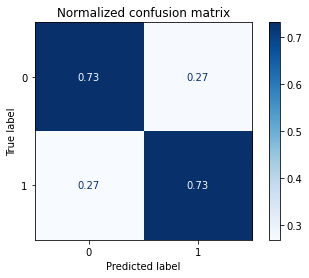

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix

#class_names=documents.label
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)


plt.show()

SVM CLASSIFIER

In [ ]:
from sklearn.svm import LinearSVC
# Train classifier
clf = LinearSVC()
clf.fit(X_train, y_train)

# Evaluate
predicted = clf.predict(X_test)
report = classification_report(y_true=y_test, y_pred=predicted)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      7411
           1       0.81      0.82      0.82      7589

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000



CONFUSION MATIRIX

Confusion matrix, without normalization
[[5981 1430]
 [1369 6220]]
Normalized confusion matrix
[[0.80704358 0.19295642]
 [0.18039267 0.81960733]]


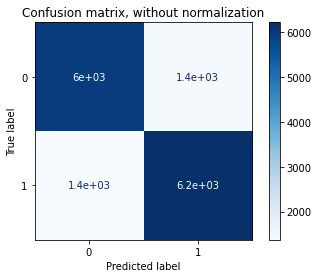

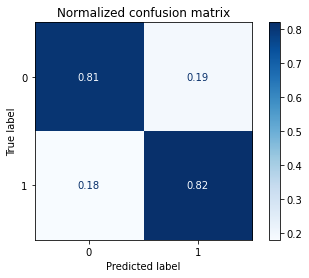

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix

#class_names=documents.label
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)


plt.show()

RANDOM FOREST CLASSIFIER

In [ ]:
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report

# Train classifier
clf = RandomForestClassifier (n_estimators=100, bootstrap = True, max_features = 'sqrt')
clf.fit(X_train, y_train)

# Evaluate
predicted = clf.predict(X_test)
report = classification_report(y_true=y_test, y_pred=predicted)
print(report)

              precision    recall  f1-score   support

           0       0.73      0.76      0.74      7411
           1       0.75      0.73      0.74      7589

    accuracy                           0.74     15000
   macro avg       0.74      0.74      0.74     15000
weighted avg       0.74      0.74      0.74     15000



CONFUSION MATIRIX

Confusion matrix, without normalization
[[5596 1815]
 [2051 5538]]
Normalized confusion matrix
[[0.75509378 0.24490622]
 [0.27025959 0.72974041]]


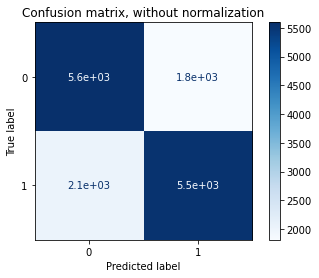

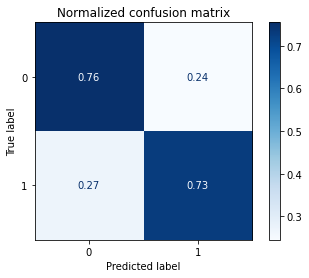

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import plot_confusion_matrix
# Plot non-normalized confusion matrix

#class_names=documents.label
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)


plt.show()